# Leaf Classification

#### Author: Yufei Zhao, UNI: yz3007
#### Date: April 2nd, 2017

## Project Introduction
- The project derives from Kaggle Competition ([Leaf Classification](https://www.kaggle.com/c/leaf-classification))
- There are estimated to be nearly half a million species of plant in the world. Classification of species has been historically problematic and often results in duplicate identifications. Automating plant recognition might have many applications, including:
    - Species population tracking and preservation
    - Plant-based medicinal research
    - Crop and food supply management
- According to binary leaf images and extracted features, including shape, margin & texture, I try to accurately identify 99 species of plants.By the way, leaves, due to their volume, prevalence, and unique characteristics, are an effective means of differentiating plant species.
- The dataset consists approximately 1,584 images of leaf specimens ( 16 samples each of 99 species ) which have been converted to binary black leaves against white backgrounds. Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.
    - train.csv - the training set
    - test.csv - the test set
    - images - leaf images( I do not use it too much )

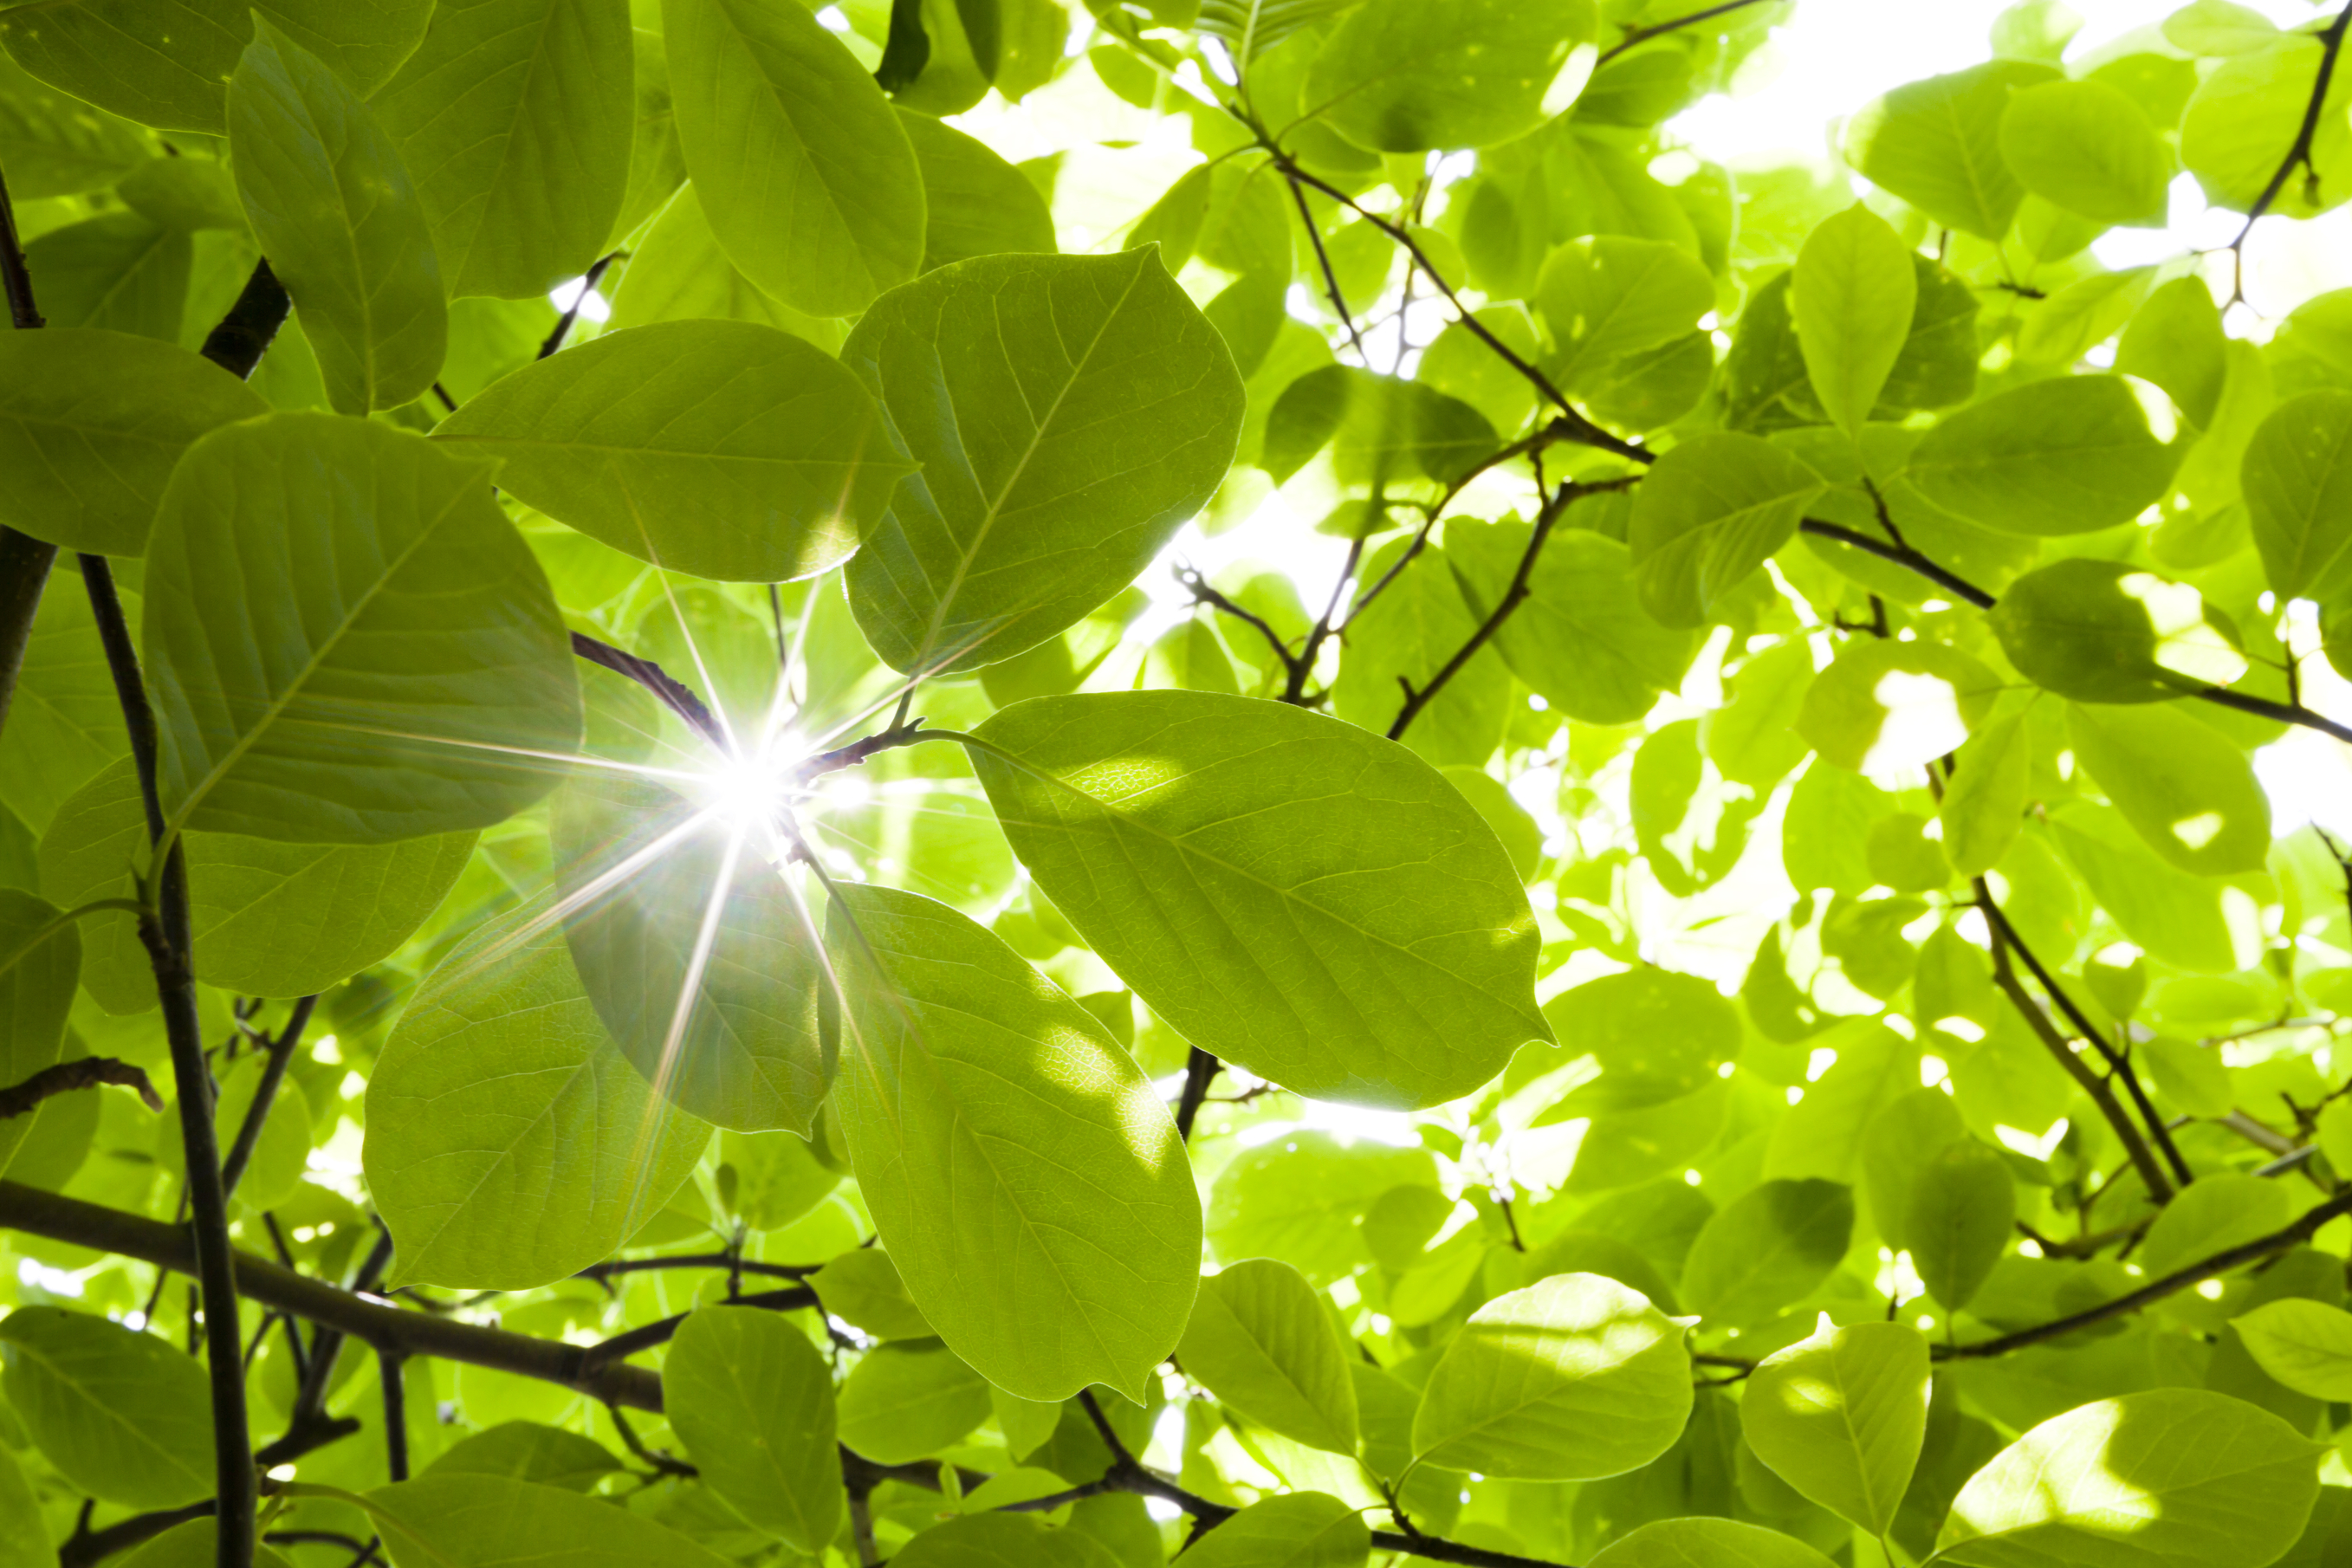

In [19]:
from IPython.display import display, Image
display(Image('bigleaves.jpg', width = 800))

## Project Outline
- Display the leaf images
- Data exploration and get common sense
- Use self-coded KNN( K nearest neighboorhood ) method to classify the leaf
    - Write KNN function and helper function called 'kernal'
    - Use 10-fold cross-validation to test the trained model and get 10 different correct rates corresponding to 10 different numbers of nearest neighborhood
    - Display the correct prediction rate plot and get the optimal nearest neighborhood
    - Make prediction on test dataset based on the KNN( k = 1 ) model and output it out as txt file
- Deploy mutiple methods to classifiy the leaf by utilizing sklearn module( contains a lot of machine learning codes such that I do not need to build everything from flat ground )
    - Preprocess the data by applying label encoder
    - Method: 'KNN', 'SVC', 'NuSVC', 'Decision Tree', 'Random Forest', 'AdaBoost','Gradient Boosting','GaussianNB', 'Linear Discriminant Analysis','Quadratic Discriminant Analysis'
    - Using stratified shuffle split method to create test datasets and validation datasets in order to get accuracy scores and log losses for each method
    - Plot accuracy scores plot and log losses plot to see which method is best
    - In terms of linear discriminant analysis ( best method ), I make projected 2D graph to visualize the each observation based on their own belonged species ( we can see the overall plot but it is a little bit messy )
        - Make one small-scale data plot whose size depends on user input 
        - Make another plot by using PCA( Principal Component Analysis ) method to plot small-scale data plot compared to above LDA method plot
    - According to LDA, I make preidtcion on test set in probabilities over 99 species and output it as csv file
- Evaluation

## Setting out on the journey

In [6]:
# library used
import operator
import os
import collections
from functools import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Display  several balck-white leaf images

Leaf 1


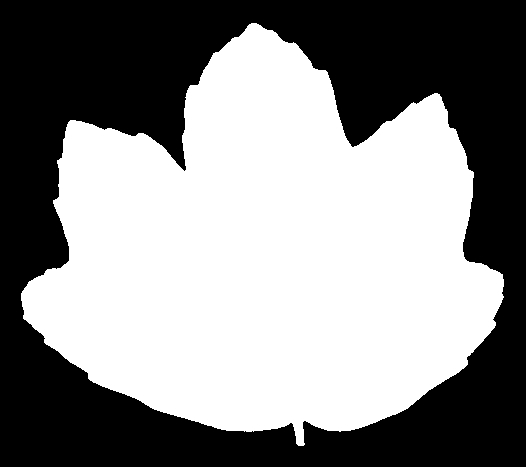

Leaf 10


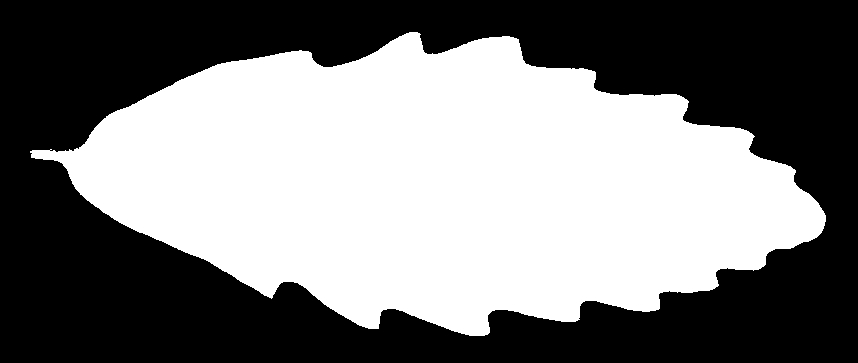

In [5]:
names = [f for f in os.listdir('images') if f.endswith('.jpg')]
for name in names[:2]:
    print('Leaf {}'.format(name.split('.')[0]))  # number is leaf order
    display(Image('images/' + name, width=300))

### Data exploration and get common sense

In [8]:
data = pd.read_csv(os.getcwd()+'/train.csv')

len(data.groupby('species')['id'].count()) # how many species

99

- We can see that there are 99 species. The issue is that we have to correctly classify it into 1 out of 99 categories given one specific leaf.

In [13]:
data.columns

Index(['id', 'species', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5',
       'margin6', 'margin7', 'margin8',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=194)

- There are totally 192 features provided along with the label and id.

In [17]:
data.info() # brief view

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 194 entries, id to texture64
dtypes: float64(192), int64(1), object(1)
memory usage: 1.5+ MB


In [18]:
data.groupby('species')['margin1','shape1','texture1'].mean().head()    # rougly looking inside

margin1    shape1  texture1
species                                      
Acer_Capillipes  0.001562  0.000614  0.001953
Acer_Circinatum  0.000195  0.000711  0.025488
Acer_Mono        0.021875  0.000627  0.002442
Acer_Opalus      0.014453  0.000628  0.101563
Acer_Palmatum    0.000195  0.001082  0.006543

- We brifly look at means of 'margin1', 'shape1', 'texture' due to large amount of features but we still can get some insights. For example, different species have different combinations of margin, shape and texture.

In [12]:
data.head() # look at first 5 obs

id                species   margin1   margin2   margin3   margin4  \
0   1            Acer_Opalus  0.007812  0.023438  0.023438  0.003906   
1   2  Pterocarya_Stenoptera  0.005859  0.000000  0.031250  0.015625   
2   3   Quercus_Hartwissiana  0.005859  0.009766  0.019531  0.007812   
3   5        Tilia_Tomentosa  0.000000  0.003906  0.023438  0.005859   
4   6     Quercus_Variabilis  0.005859  0.003906  0.048828  0.009766   

    margin5   margin6   margin7  margin8    ...      texture55  texture56  \
0  0.011719  0.009766  0.027344      0.0    ...       0.007812   0.000000   
1  0.025391  0.001953  0.019531      0.0    ...       0.000977   0.000000   
2  0.003906  0.005859  0.068359      0.0    ...       0.154300   0.000000   
3  0.021484  0.019531  0.023438      0.0    ...       0.000000   0.000977   
4  0.013672  0.015625  0.005859      0.0    ...       0.096680   0.000000   

   texture57  texture58  texture59  texture60  texture61  texture62  \
0   0.002930   0.002930   0.035156        0.0        0.0   0.004883   
1   0.000000   0.000977   0.023438        0.0        0.0   0.000977   
2   0.005859   0.000977   0.007812        0.0        0.0   0.000000   
3   0.000000   0.000000   0.020508        0.0        0.0   0.017578   
4   0.021484   0.000000   0.000000        0.0        0.0   0.000000   

   texture63  texture64  
0   0.000000   0.025391  
1   0.039062   0.022461  
2   0.020508   0.002930  
3   0.000000   0.047852  
4   0.000000   0.031250  

[5 rows x 194 columns]

### KNN(K Nearest Neighborhood) Method which coded by myself

- Try to use 10-fold cross validation to test the method

In [21]:
rand = np.random.RandomState(0) # set random seed

In [22]:
# get randomly sampled data index
fold = 10
fold_size = int(len(data.index)/fold)
ls = reduce(operator.add,[[i]*fold_size for i in range(fold)])
number = np.array(ls)
# random index preparing for selecting
index = rand.choice(number, replace = False, size = number.shape)

#### kernal helper function

In [24]:
##calculate the correct prediction rates on test_leaf
#@param test_leaf, test data set
#@param train, trainning data set
#@param k, k nearest neighbors
#@return return 1 correct rates on one of folder
def kernal(test_leaf, train,k):
    
    train_data = train.iloc[:,2:]
    train_label = train['species']
    ''' have to reindex it
        using np.array to solve the bug, otherwise it will use previous index when we %train_label[order]
        you can also use train_label.iloc[order] to solve it. implicit reference
    '''
    train_label = np.array(train_label)
    
    total = 0
    length = len(test_leaf.index)
    for i in range(length):
        # a complete leaf including label
        leaf = test_leaf.iloc[i,:]
        leaf_label = leaf['species']
        leaf_data = leaf['margin1':]
        
        # using euclidean to calculate the distance
        sqr_diff = np.add.reduce((train_data-leaf_data)**2,axis = 1)
        order = np.argsort(sqr_diff)[:k]
        labels = train_label[order]
        
        c = collections.Counter(labels)
        #for key, value in c.most_common(1):
            #print(key)
        pred_label = c.most_common(1)[0][0]
        if (pred_label == leaf_label):
            total += 1
    #print(total/length)
    return(total/length)

#### KNN function

In [26]:
##calculate the overall correct prediction rates
#@param k, k nearest neighbors
#@param data, original data
#@param index, randomly index in order for 10 folder cross validation
#@return average correct prediction rates over 10 folders
def KNN(k,data, index):
    correct = []
    for i in range(10):
        valid_set = data[index == i]
        train_set = data[index != i]

        correct_rate = kernal(valid_set, train_set,k)
        correct.append(correct_rate)
        
    return sum(correct)/len(correct)

In [16]:
knn = []
for i in range(1,10):
    value = KNN(i,data,index)
    knn.append(value)
knn = np.array(knn)
np.savetxt('knn_test.txt', knn, delimiter=',')

- Since it takes nearly 10 minutes to run the above codes, then I save the output to knn_test.txt
- My algorithm is not very efficient since I repeated calculating the KNN of one leaf. For example, the results of knn=9 also include results of knn=1

In [27]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [30]:
knn_data = np.loadtxt('knn_test.txt', delimiter = ',')

#### Display the correct prediction rate plot and get the optimal nearest neighborhood

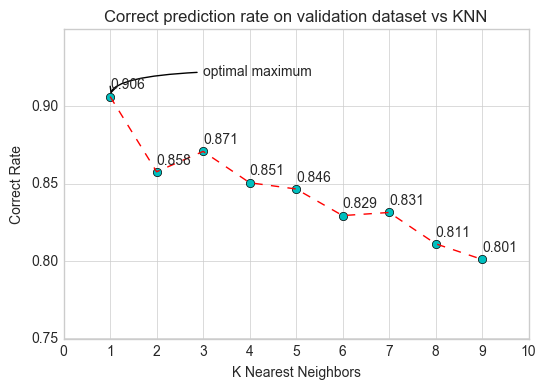

In [29]:
fig = plt.figure()
ax = plt.axes()
x = np.array(range(1,10))
ax.plot(x,knn_data,'co', x, knn_data,'r--')
ax.annotate('optimal maximum', xy=(1, knn_data[0]), xytext=(3, 0.92),
            arrowprops=dict(arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90"))
ax.xaxis.set_major_locator(plt.MaxNLocator(10)) # set how many ticks
around = np.around(knn_data, decimals = 3)
for i in range(len(knn_data)):
    ax.text(i+1,knn_data[i]+0.005, around[i])
ax.set(xlim = (0,10), ylim = (0.75, 0.95),
       xlabel = 'K Nearest Neighbors', ylabel = 'Correct Rate',
       title='Correct prediction rate on validation dataset vs KNN')
plt.show()

- Based on above graph, we can see that we can get most accurate results when I choose K as 1 with 90.6% accuracy

In [31]:
# try to predict test data set using knn=1 method based on trainning data set
# but I do not know the result since it is protected by Kaggle website.
test = pd.read_csv('test.csv')
test.columns # to identify anything different

Index(['id', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5', 'margin6',
       'margin7', 'margin8', 'margin9',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=193)

#### Output prediction labels (KNN = 1)

In [32]:
train_data = data.iloc[:,2:]
train_label = data['species'].values
ls = []
for i in range(len(test.index)):
    leaf = test.iloc[i,1:]
    sqr_diff = np.add.reduce((train_data-leaf)**2,axis = 1)
    order = np.argsort(sqr_diff)[:1]
    labels = train_label[order][0]
    ls.append(labels)
label = np.array(ls)
index = np.array(range(1,len(test.index)+1))

a = list(data['species'].values) # try to get maximum length of string in species
maximum = max([len(i) for i in a])

output = np.zeros(label.size,dtype=[('var1', int), ('var2', 'U{}'.format(maximum))])
output['var1'] = index
output['var2'] = label
np.savetxt('knn_prediction_result_on_testDataSet.txt',output,delimiter = ',', fmt = '%3.i  %10s')

### Utalizing the sklearn module to classify leaves

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

#### Data peprocessing (convert species string to number)

In [102]:
data = pd.read_csv(os.getcwd()+'/train.csv')
le = LabelEncoder()
le.fit(data.species.values)
labels = le.transform(data.species.values) # species label
data = data.drop(['id','species'], axis = 1)

In [58]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

#### Deploy 10 classifiers

In [62]:
sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="rbf", probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

Acc = []
Lloss = []
for train_index, test_index in sss.split(data, labels):
    train_data = data.values[train_index]
    test_data = data.values[test_index]
    train_label = labels[train_index]
    test_label = labels[test_index]
    
    acc = []
    lloss = []
    for clf in classifiers:
        clf.fit(train_data, train_label)
        prediction = clf.predict(test_data)
        
        score = accuracy_score(test_label, prediction)  # accuracy score
        
        pred = clf.predict_proba(test_data)
        loss = log_loss(test_label, pred)#log loss
        
        acc.append(score)
        lloss.append(loss)
        
    Acc.append(acc)
    Lloss.append(lloss)
    
accuracy = np.add.reduce(Acc)/len(Acc)
logloss = np.add.reduce(Lloss)/len(Lloss)

np.savetxt('accuracy.txt', accuracy, delimiter=',')
np.savetxt('logloss.txt', logloss, delimiter=',')

- Since it takes nearly 10 minutes to run the above codes, then I save the outputs to accuracy.txt and logloss.txt respectively 

#### Make comparable classifier accuracy plot and log loss plot

In [59]:
accuracy = np.loadtxt('accuracy.txt', delimiter = ',')
logloss =np.loadtxt('logloss.txt', delimiter = ',')

classi = np.array(['KNN', 'SVC', 'NuSVC', 'DecisionTree', 'RandomForest', 'AdaBoost','GradientBoosting',
                        'GaussianNB', 'LinearDiscriminantAnalysis','QuadraticDiscriminantAnalysis'])
di = {'classifier': classi, 'accuracy' : accuracy, 'logloss' :logloss}
final = pd.DataFrame.from_dict(di)

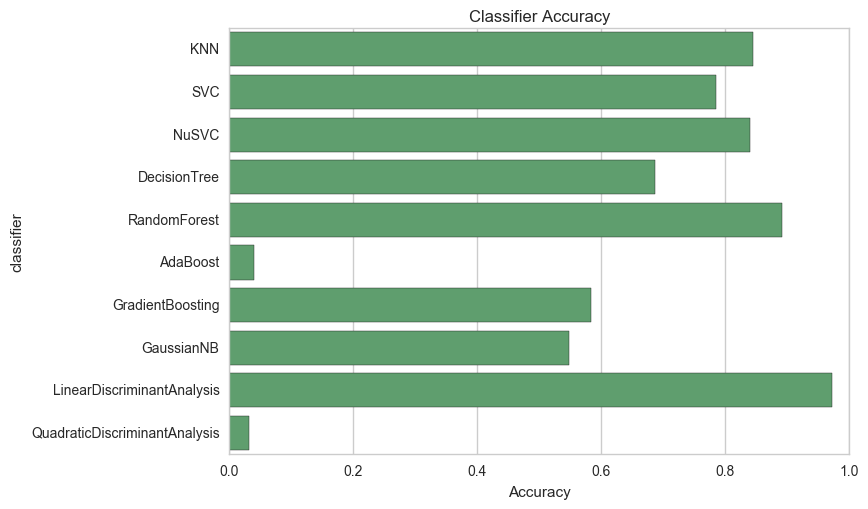

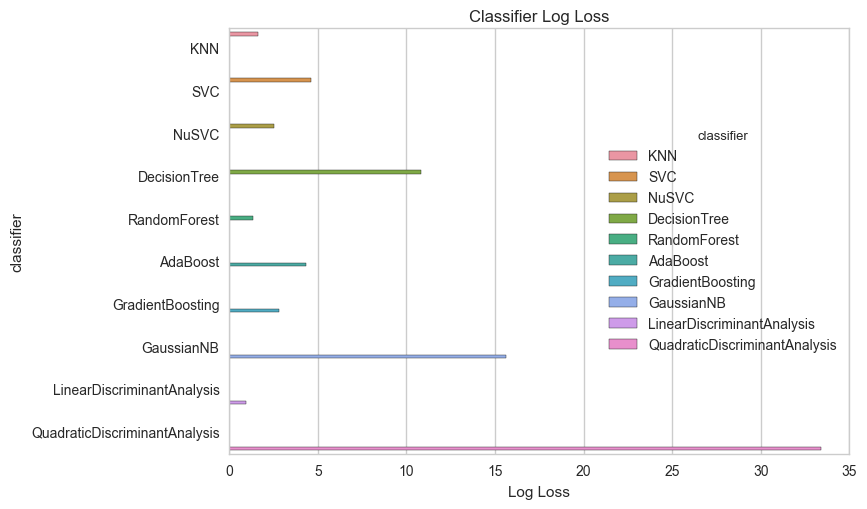

In [60]:
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

sns.barplot(x='accuracy', y='classifier', data=final, color = 'g')

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')
plt.show()

sns.barplot(x='logloss', y='classifier', data=final, hue = "classifier")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

- Based on above plots, we can see that we can get most classifier accuracy and least classifier log loss if we use linear discrminant analysis method

#### Using linear discriminant analysis to classifiy leaf

In [61]:
import random
random.seed(23)

In [62]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(data.values, labels).transform(data.values)

names = le.classes_   # get the name tents
unique = len(set(labels)) # how many different species label
r = (0.0,0.25,0.5,0.75,1.0)
colors = [(i,j,k) for i in r for j in r for k in r] # get RGB combinations by nested list comprehension

# refulling 10 times
for i in range(10):
    random.shuffle(colors)  

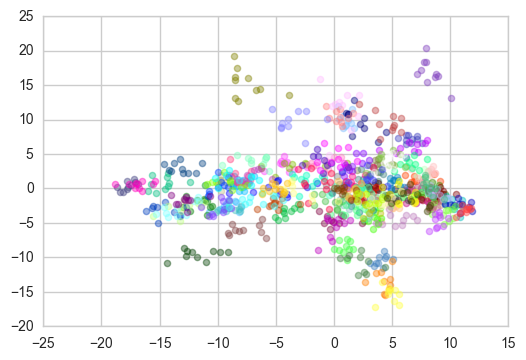

In [63]:
%matplotlib inline
plt.figure()
for color, i,name in zip(colors, range(unique), names):
    plt.scatter(X_r[labels == i, 0], X_r[labels == i, 1], color = color, alpha = 0.4, lw = 1,
               label = name)
plt.show()

- As we can see above scatter plot, it shows us the dispersion of overall 990 obs (99 species) when they are projected into 2 most variance dimensions.
- It is very colorful and some patterns are outstanding, however, it is a little bit of messy

#### Small-scale of 2D LDA dataset 

Please enter the integer stands for how many first classes displayed: 5


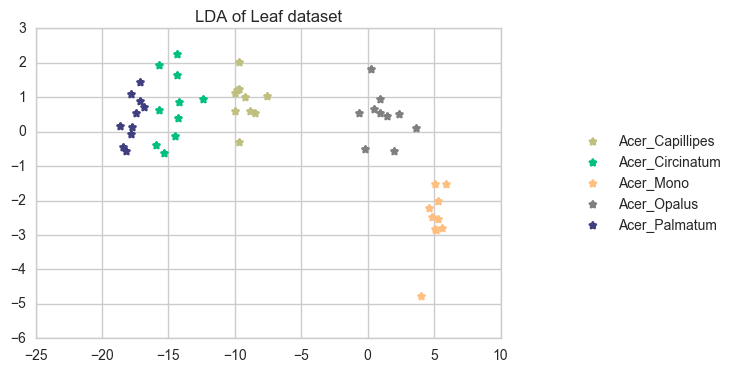

In [64]:
%matplotlib inline
counter = input('Please enter the integer stands for how many first classes displayed: ')
counter = int(counter)
for color, i,name in zip(colors, range(unique), names):
    plt.scatter(X_r[labels == i, 0], X_r[labels == i, 1], color = color, alpha = 1, lw = 2,
               label = name,marker = '*')
    counter -= 1
    if(counter == 0):
        break
        
plt.legend(shadow=False, scatterpoints=1, fontsize = 'medium',loc='right',bbox_to_anchor=(1.5, 0.5))
plt.title('LDA of Leaf dataset')
plt.show()

- we can see that different colors means different separable species
- The species clusters are scattered in 2D plot
- LDA method can help us classify the leaf effectively and efficiently

#### Small-scale of 2D PCA dataset 

In [65]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_r2 = pca.fit(data.values).transform(data.values)

Please enter the integer stands for how many first classes displayed: 5


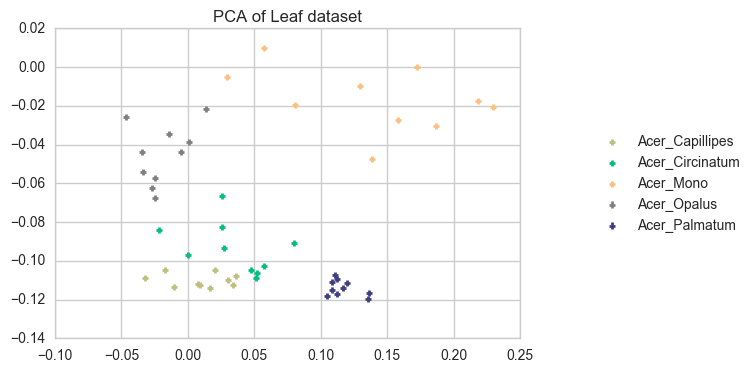

In [66]:
%matplotlib inline
plt.figure()
counter = input('Please enter the integer stands for how many first classes displayed: ')
counter = int(counter)
for color, i, name in zip(colors, range(unique), names):
    plt.scatter(X_r2[labels == i, 0], X_r2[labels == i, 1], color=color, alpha=1, lw=2,
                label=name, marker = '+')
    counter -= 1
    if(counter == 0):
        break
        
plt.legend(shadow=False, scatterpoints=1, fontsize = 'medium',loc='right',bbox_to_anchor=(1.5, 0.5))
plt.title('PCA of Leaf dataset')
plt.show()
    

- we can see that different colors means different separable species
- The species clusters are mostly scattered in 2D plot
- PCA method may help us classify the leaf well
- Futher imporvement: we may use PCA to classify the leaf

#### According to LDA, I make preidtcion on test set in probabilities over 99 species and output it as csv file

In [100]:
test = pd.read_csv('test.csv')
test_data = test.iloc[:,1:].values
test_ids = test['id']

In [103]:
clf = LinearDiscriminantAnalysis()
clf.fit(data.values, labels)
result = clf.predict_proba(test_data)
df = pd.DataFrame(result,columns=le.classes_)
df.insert(0, 'id', test_ids)
df.to_csv('leaf_classifer_prob.csv', index = False)
df.head()

id  Acer_Capillipes  Acer_Circinatum      Acer_Mono   Acer_Opalus  \
0   4     5.956416e-61    3.872117e-131  4.923615e-109  8.144226e-11   
1   7     2.257212e-83    3.121396e-156   1.262776e-81  5.643123e-21   
2   9     1.277739e-45     2.499793e-01   2.399643e-78  2.958381e-28   
3  12     2.750659e-38     1.273511e-01  1.915568e-136  6.635473e-28   
4  13     7.635792e-12     3.216445e-48  2.602859e-101  3.987252e-46   

   Acer_Palmatum   Acer_Pictum  Acer_Platanoids   Acer_Rubrum  Acer_Rufinerve  \
0   0.000000e+00  4.554510e-64    2.922527e-103  6.385992e-84    3.912086e-75   
1  1.371230e-302  4.981996e-47     1.012007e-21  2.695623e-56    2.098105e-66   
2   1.914517e-20  8.134587e-58    2.181108e-107  3.343140e-24    2.499792e-01   
3  1.102980e-225  9.143356e-99     2.776479e-95  1.887768e-43    5.272737e-18   
4  1.412902e-225  1.029456e-88     2.911238e-75  4.610281e-21    1.292192e-01   

        ...         Salix_Fragilis  Salix_Intergra    Sorbus_Aria  \
0       ...          4.999369e-169    2.592082e-52  2.368761e-119   
1       ...          1.619139e-156    9.528604e-58  8.685023e-135   
2       ...           3.050014e-84    7.500435e-68  2.834429e-136   
3       ...          1.949714e-121    2.344711e-95  8.623375e-107   
4       ...           1.569808e-58    2.157716e-70   1.626904e-74   

   Tilia_Oliveri  Tilia_Platyphyllos  Tilia_Tomentosa  Ulmus_Bergmanniana  \
0   4.995059e-71        1.573088e-69     6.529121e-55       1.096112e-117   
1   7.308119e-72        4.419783e-93     3.428585e-41       1.726366e-109   
2   1.037462e-55        2.157511e-38     8.299597e-05        3.218959e-13   
3   2.601438e-65        3.354449e-42     3.123151e-13        1.273511e-01   
4   2.139496e-47        7.002616e-02     1.292192e-01        1.292192e-01   

   Viburnum_Tinus  Viburnum_x_Rhytidophylloides  Zelkova_Serrata  
0    1.070795e-68                  5.741916e-71     1.501994e-94  
1    1.298508e-29                 6.222686e-127     1.202071e-61  
2    4.826533e-79                 1.886576e-152     3.532384e-12  
3    2.286721e-74                 1.681890e-140     1.273511e-01  
4    6.800048e-59                 6.999778e-125     1.302169e-42  

[5 rows x 100 columns]

- Above table shows first 5 rows probability info over 99 species class.
- At the same row, the higher probability, the most likey the leaf belong to the species class

## Evaluation

- Problems encountered:
    - In this project, the codes are not very efficient in some parts and it takes several minutes to run when I heavily apply machine learning codes and do 10-fold cross-validation. 
    - It takes me a long time to fully read and utilize enormous API in machine learning and ploting area such as sklearn, matplotlib, seaborn, numpy, pandas, but I do gain a lot of hands-on experience

- Pros in Python
    - As we all know, most of professionals use Python to do machine learning analysis. Hence I am so lucky that I can use my Python knowledge learned from Professor Stead in order to deploy leaf classification pythonically. 
    - By using python buit-in modules and plenty of useful modules, I can write my codes compactly, neatly and explictly

- Cons in Python
    - Since my major is Statistics, I use R language a lot. From my own perspective, the for loop is not very efficient in Python. However, we can use %apply, %lappy, %tapply, etc to reduce the complexity of 'for' loop in R since they are internal buit-in and optimal

- Overall, Python is a very nice and friendly tool to machine learning topic since it can process tons of data efficiently and utilze different modules to help us. R is secondary choice since people do not use it a lot in industry area instead of academic area. Java is OOP language and it is very hard for me to imagine using Java to do machine learning. 